In [18]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [19]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [20]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [21]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [22]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [23]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [24]:
# Save references to each table
Msr = Base.classes.measurement
Stn = Base.classes.station

In [25]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [26]:
# Find the most recent date in the data set.
recent = session.query(func.max(Msr.date)).scalar()
print("Most recent date in the dataset:", recent)

Most recent date in the dataset: 2017-08-23


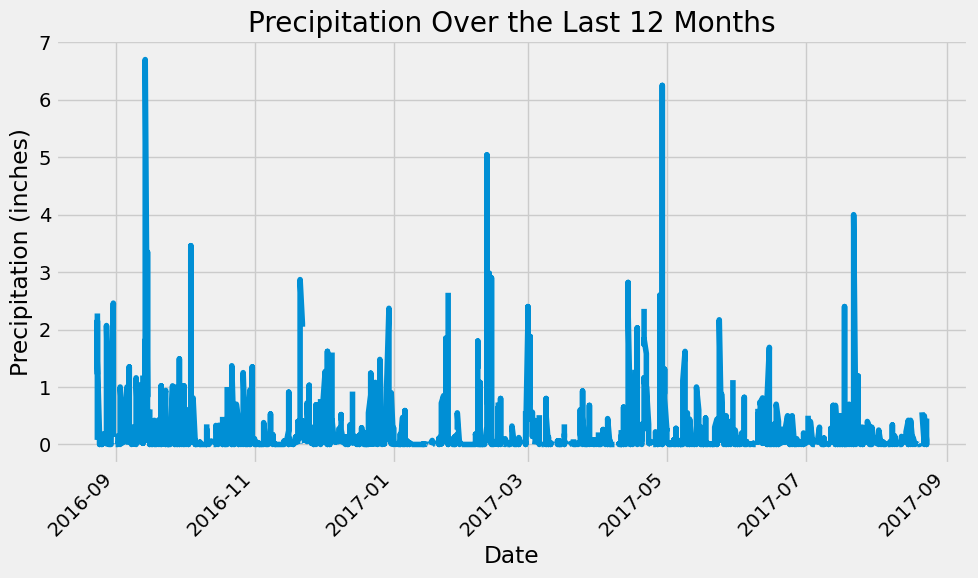

In [27]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.
year_ago = dt.datetime.strptime(recent, "%Y-%m-%d") - dt.timedelta(days=365)

# Calculate the date one year from the last date in data set.
precipitation_data = (
    session.query(Msr.date, Msr.prcp)
    .filter(Msr.date >= year_ago)
    .order_by(Msr.date)
    .all()
)

# Perform a query to retrieve the data and precipitation scores
precipitation_df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df['date'] = pd.to_datetime(precipitation_df['date'])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x='date', y='precipitation', kind='line', figsize=(10,6), legend=False)
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.title("Precipitation Over the Last 12 Months")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [28]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_summary = precipitation_df['precipitation'].describe()
print(precipitation_summary)

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64


# Exploratory Station Analysis

In [29]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Stn.station)).scalar()
print("Total number of stations:", total_stations)

Total number of stations: 9


In [30]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_activity = (
    session.query(Msr.station, func.count(Msr.station).label("num"))
    .group_by(Msr.station)
    .order_by(func.count(Msr.station).desc())
    .all()
)
for station, num in station_activity:
    print(f"Station: {station}, Count: {num}")


Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [31]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_activity = station_activity[0][0]

temperature_stats = (
    session.query(
        func.min(Msr.tobs).label("min_temp"),
        func.max(Msr.tobs).label("max_temp"),
        func.avg(Msr.tobs).label("avg_temp")
    )
    .filter(Msr.station == most_activity)
    .all()
)

min_temp, max_temp, avg_temp = temperature_stats[0]
print(f"Station: {most_activity}")
print(f"Lowest Temperature: {min_temp}°F")
print(f"Highest Temperature: {max_temp}°F")
print(f"Average Temperature: {avg_temp:.2f}°F")

Station: USC00519281
Lowest Temperature: 54.0°F
Highest Temperature: 85.0°F
Average Temperature: 71.66°F


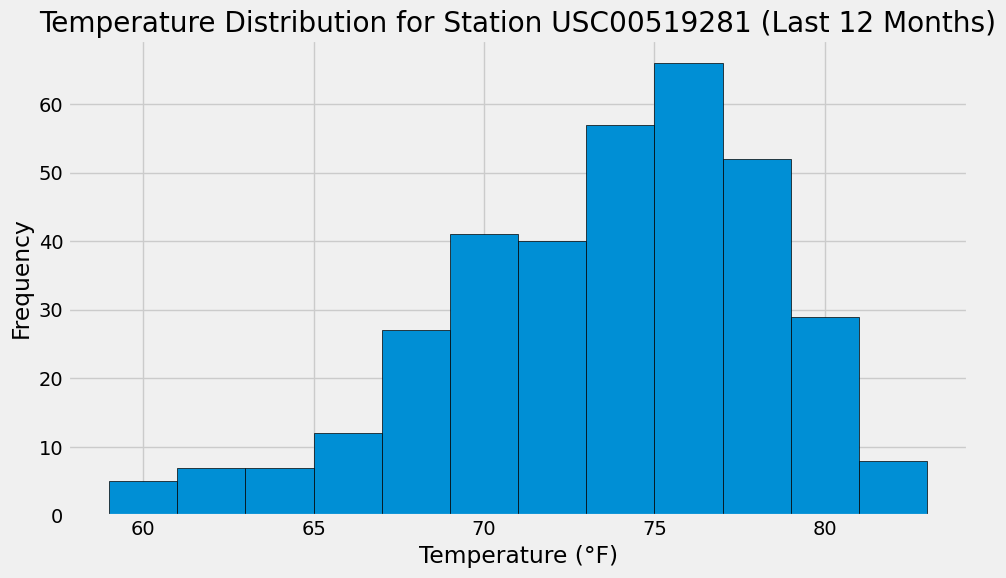

In [32]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_ago = dt.datetime.strptime(recent, "%Y-%m-%d") - dt.timedelta(days=365)

temperature_data = (
    session.query(Msr.tobs)
    .filter(Msr.station == most_activity)
    .filter(Msr.date >= year_ago)
    .all()
)

# Save as df and plot
temperature_df = pd.DataFrame(temperature_data, columns=['tobs'])
temperature_df.plot(kind='hist', bins=12, figsize=(10,6), legend=False, edgecolor='black')
plt.title(f"Temperature Distribution for Station {most_activity} (Last 12 Months)")
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Close Session

In [33]:
# Close Session
session.close()